In [1]:
%matplotlib inline


# MaD DiGait Pipeline

This pipeline showcases the current gait analysis pipeline used by the MaD-Lab with all required steps:
Preprocessing -> Stride Segmentation -> Event Detection -> Trajectory Reconstruction -> Parameter Estimation

This should serve as a compact example that can be copied and pasted into new projects.
For more details on the individual steps have a look at the extended examples and the documentation of the main classes:

- `Preprocessing <example_preprocessing>`
- `Stride Segmentation (BarthDTW) <example_barth_stride_segmentation>`
- `Event Detection (RamppEventDetection) <example_rampp_event_detection>`
- `Trajectory Reconstruction (double Integration) <example_preprocessing>`
- `Temporal Parameters <example_temporal_parameters>` and `Spatial Parameters <example_spatial_parameters>`


In [1]:
pip install gaitmap

Note: you may need to restart the kernel to use updated packages.


## Load example data



In [312]:
import numpy as np
import pandas as pd 

np.random.seed(0)

example_dataset = pd.read_csv('16thmay2.csv', index_col=False)
sampling_rate_hz = 50

from gaitmap.preprocessing import sensor_alignment

In [313]:
type(example_dataset)

pandas.core.frame.DataFrame

In [314]:
example_dataset.head(1)

,Time,Device name设备名称,Acceleration X(g),Acceleration Y(g),Acceleration Z(g),Angular velocity X(°/s),Angular velocity Y(°/s),Angular velocity Z(°/s),Angle X(°),Angle Y(°),Angle Z(°),Magnetic field X(ʯt),Magnetic field Y(ʯt),Magnetic field Z(ʯt),Temperature(℃),Quaternions 0(),Quaternions 1(),Quaternions 2(),Quaternions 3()
0,14:51:34.493,WT901BLE68(d8:09:5a:ca:b6:e0),-0.097,-0.992,0.038,1.465,-0.793,0.671,-87.973,5.521,113.698,38.024,-10.878,-18.816,31.49,0.36896,-0.40808,-0.56189,0.61768


In [315]:
renamed = {'Device name设备名称':'Device name','Acceleration X(g)':'acc_x','Acceleration Y(g)':'acc_y','Acceleration Z(g)':'acc_z',
'Angular velocity X(°/s)':'gyr_x','Angular velocity Y(°/s)':'gyr_y','Angular velocity Z(°/s)':'gyr_z'}

example_dataset = example_dataset.rename(columns=renamed)
example_dataset.head()

,Time,Device name,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,Angle X(°),Angle Y(°),Angle Z(°),Magnetic field X(ʯt),Magnetic field Y(ʯt),Magnetic field Z(ʯt),Temperature(℃),Quaternions 0(),Quaternions 1(),Quaternions 2(),Quaternions 3()
0,14:51:34.493,WT901BLE68(d8:09:5a:ca:b6:e0),-0.097,-0.992,0.038,1.465,-0.793,0.671,-87.973,5.521,113.698,38.024,-10.878,-18.816,31.49,0.36896,-0.40808,-0.56189,0.61768
1,14:51:34.493,WT901BLE68(d8:09:5a:ca:b6:e0),-0.098,-0.990,0.040,1.526,-0.671,0.366,-87.946,5.526,113.741,38.024,-10.878,-18.816,31.49,0.36896,-0.40808,-0.56189,0.61768
2,14:51:34.498,WT901BLE68(cc:c4:7a:a1:fe:ea),0.995,0.005,0.031,0.244,-1.282,-0.549,0.341,-88.088,152.281,-22.736,-54.292,-26.558,31.87,-0.17075,-0.67010,0.17029,-0.70193
3,14:51:34.498,WT901BLE68(cc:c4:7a:a1:fe:ea),0.995,0.006,0.031,0.244,-0.977,-0.244,0.659,-88.110,151.990,-22.736,-54.292,-26.558,31.87,-0.17075,-0.67010,0.17029,-0.70193
4,14:51:34.530,WT901BLE68(cc:c4:7a:a1:fe:ea),0.995,0.006,0.030,0.305,-0.488,0.000,0.829,-88.121,151.853,-22.736,-54.292,-26.558,31.87,-0.17075,-0.67010,0.17029,-0.70193


In [316]:
example_dataset['Time'] = pd.to_datetime(example_dataset['Time'], format=' %H:%M:%S.%f')

# Only calculate angular velocities where time difference is not zero
example_dataset['Δt'] = example_dataset['Time'].diff().dt.total_seconds()
mask = example_dataset['Δt'] != 0

example_dataset['ω_x'] = np.where(mask, example_dataset['Angle X(°)'].diff() / example_dataset['Δt'], 0)
example_dataset['ω_y'] = np.where(mask, example_dataset['Angle Y(°)'].diff() / example_dataset['Δt'], 0)
example_dataset['ω_z'] = np.where(mask, example_dataset['Angle Z(°)'].diff() / example_dataset['Δt'], 0)

# Drop the first row (which will have NaN due to diff())
example_dataset = example_dataset.iloc[1:]

# Drop rows where time difference is 0
example_dataset = example_dataset[example_dataset['Δt'] != 0]

example_dataset

,Time,Device name,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,Angle X(°),Angle Y(°),...,Magnetic field Z(ʯt),Temperature(℃),Quaternions 0(),Quaternions 1(),Quaternions 2(),Quaternions 3(),Δt,ω_x,ω_y,ω_z
2,1900-01-01 14:51:34.498,WT901BLE68(cc:c4:7a:a1:fe:ea),0.995,0.005,0.031,0.244,-1.282,-0.549,0.341,-88.088,...,-26.558,31.87,-0.17075,-0.67010,0.17029,-0.70193,0.005,17657.400000,-18722.800000,7708.000000
4,1900-01-01 14:51:34.530,WT901BLE68(cc:c4:7a:a1:fe:ea),0.995,0.006,0.030,0.305,-0.488,0.000,0.829,-88.121,...,-26.558,31.87,-0.17075,-0.67010,0.17029,-0.70193,0.032,5.312500,-0.343750,-4.281250
6,1900-01-01 14:51:34.532,WT901BLE68(d8:09:5a:ca:b6:e0),-0.098,-0.993,0.038,1.526,-0.488,0.122,-87.913,5.532,...,-18.816,31.49,0.36896,-0.40808,-0.56189,0.61768,0.002,-44390.500000,46829.500000,-19031.500000
8,1900-01-01 14:51:34.534,WT901BLE68(d8:09:5a:ca:b6:e0),-0.098,-0.994,0.036,2.136,-0.427,-0.061,-87.841,5.537,...,-18.816,31.49,0.36896,-0.40808,-0.56189,0.61768,0.002,19.500000,0.000000,16.500000
14,1900-01-01 14:51:34.540,WT901BLE68(d8:09:5a:ca:b6:e0),-0.096,-0.994,0.044,0.977,0.000,-0.549,-87.583,5.460,...,-18.816,31.49,0.36896,-0.40808,-0.56189,0.61768,0.006,3.666667,-1.833333,2.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,1900-01-01 14:52:04.258,WT901BLE68(cc:c4:7a:a1:fe:ea),0.911,0.542,0.017,46.875,-8.972,53.284,-100.432,-64.440,...,-50.078,32.57,0.61105,0.70380,-0.26144,0.25061,0.029,28.034483,25.000000,-2.275862
2970,1900-01-01 14:52:04.288,WT901BLE68(cc:c4:7a:a1:fe:ea),0.913,0.525,0.064,47.119,7.019,12.329,-99.261,-64.435,...,-50.078,32.57,0.61105,0.70380,-0.26144,0.25061,0.030,24.200000,-6.966667,-3.300000
2972,1900-01-01 14:52:04.349,WT901BLE68(cc:c4:7a:a1:fe:ea),1.002,0.416,0.069,48.401,16.602,-31.677,-96.575,-66.000,...,-50.372,32.57,0.61105,0.70380,-0.26144,0.25061,0.061,22.524590,-16.655738,-11.885246
2974,1900-01-01 14:52:04.409,WT901BLE68(cc:c4:7a:a1:fe:ea),1.025,0.285,0.082,48.096,17.517,-77.698,-94.345,-69.554,...,-50.372,32.57,0.28448,0.51135,-0.50171,0.63699,0.060,20.516667,-33.133333,-9.333333


In [317]:
example_dataset.drop(['Magnetic field X(ʯt)', 'Magnetic field Y(ʯt)', 'Magnetic field Z(ʯt)',
                          'Temperature(℃)', 'Quaternions 0()', 'Quaternions 1()', 'Quaternions 2()', 'Quaternions 3()'], axis=1, inplace=True)


In [318]:
def df_to_dict_of_dfs(df):
        device_names = df['Device name'].unique()
        dfs_dict = {}
        for device_name in device_names:
            device_df = df[df['Device name'] == device_name].copy()
            device_df.drop(columns='Device name', inplace=True)
            dfs_dict[device_name] = device_df.reset_index(drop=True)
        return dfs_dict

dfs_dict = df_to_dict_of_dfs(example_dataset)
dfs_dict

{'WT901BLE68(cc:c4:7a:a1:fe:ea)':                        Time  acc_x  acc_y  acc_z   gyr_x   gyr_y    gyr_z   
 0   1900-01-01 14:51:34.498  0.995  0.005  0.031   0.244  -1.282   -0.549  \
 1   1900-01-01 14:51:34.530  0.995  0.006  0.030   0.305  -0.488    0.000   
 2   1900-01-01 14:51:34.736  0.994  0.005  0.031   0.244   0.122    0.122   
 3   1900-01-01 14:51:34.737  0.995  0.006  0.030   0.244  -1.343    0.427   
 4   1900-01-01 14:51:34.768  0.994  0.005  0.026   0.244   0.610    1.099   
 ..                      ...    ...    ...    ...     ...     ...      ...   
 594 1900-01-01 14:52:04.258  0.911  0.542  0.017  46.875  -8.972   53.284   
 595 1900-01-01 14:52:04.288  0.913  0.525  0.064  47.119   7.019   12.329   
 596 1900-01-01 14:52:04.349  1.002  0.416  0.069  48.401  16.602  -31.677   
 597 1900-01-01 14:52:04.409  1.025  0.285  0.082  48.096  17.517  -77.698   
 598 1900-01-01 14:52:04.438  1.236 -0.838  0.174  41.199  55.298 -146.362   
 
      Angle X(°)  Angle Y(°) 

In [319]:

# Print the dictionary of DataFrames
for device_name, device_df in dfs_dict.items():
    print(f"Device Name: {device_name}")
    print(device_df)
    print()

Device Name: WT901BLE68(cc:c4:7a:a1:fe:ea)
                       Time  acc_x  acc_y  acc_z   gyr_x   gyr_y    gyr_z   
0   1900-01-01 14:51:34.498  0.995  0.005  0.031   0.244  -1.282   -0.549  \
1   1900-01-01 14:51:34.530  0.995  0.006  0.030   0.305  -0.488    0.000   
2   1900-01-01 14:51:34.736  0.994  0.005  0.031   0.244   0.122    0.122   
3   1900-01-01 14:51:34.737  0.995  0.006  0.030   0.244  -1.343    0.427   
4   1900-01-01 14:51:34.768  0.994  0.005  0.026   0.244   0.610    1.099   
..                      ...    ...    ...    ...     ...     ...      ...   
594 1900-01-01 14:52:04.258  0.911  0.542  0.017  46.875  -8.972   53.284   
595 1900-01-01 14:52:04.288  0.913  0.525  0.064  47.119   7.019   12.329   
596 1900-01-01 14:52:04.349  1.002  0.416  0.069  48.401  16.602  -31.677   
597 1900-01-01 14:52:04.409  1.025  0.285  0.082  48.096  17.517  -77.698   
598 1900-01-01 14:52:04.438  1.236 -0.838  0.174  41.199  55.298 -146.362   

     Angle X(°)  Angle Y(°)  Ang

In [320]:
from gaitmap.utils.datatype_helper import get_multi_sensor_names
get_multi_sensor_names(dfs_dict)

dict_keys(['WT901BLE68(cc:c4:7a:a1:fe:ea)', 'WT901BLE68(d8:09:5a:ca:b6:e0)'])

In [321]:
from gaitmap.utils.datatype_helper import is_sensor_data

is_sensor_data(dfs_dict, frame="sensor")


'multi'

In [322]:
is_sensor_data(dfs_dict['WT901BLE68(d8:09:5a:ca:b6:e0)'], frame="sensor")

'single'

## Preprocessing
Fix the alignment between the sensor coordinate system and the gaitmap coordinate system.
This will be different for each sensor position and recording.



In [323]:
from scipy.spatial.transform import Rotation

# For multiple sensors, we write down the rotation matrices for each sensor into a dict
rotation_matrices = {
      'WT901BLE68(d8:09:5a:ca:b6:e0)': Rotation.from_matrix(np.array([[ 0, 1,  0], [ 0,  0,  1], [1,  0,  0]])),
      'WT901BLE68(cc:c4:7a:a1:fe:ea)': Rotation.from_matrix(np.array([[ 0,  -1,  0], [ 0,  0, -1], [1,  0,  0]]))
}
from gaitmap.utils.rotations import rotate_dataset

# We assume `data` has two sensors with the same names as in the dict above
data = rotate_dataset(dfs_dict, rotation_matrices)
data

{'WT901BLE68(cc:c4:7a:a1:fe:ea)':                        Time  acc_x  acc_y  acc_z   gyr_x    gyr_y   gyr_z   
 0   1900-01-01 14:51:34.498 -0.005 -0.031  0.995   1.282    0.549   0.244  \
 1   1900-01-01 14:51:34.530 -0.006 -0.030  0.995   0.488    0.000   0.305   
 2   1900-01-01 14:51:34.736 -0.005 -0.031  0.994  -0.122   -0.122   0.244   
 3   1900-01-01 14:51:34.737 -0.006 -0.030  0.995   1.343   -0.427   0.244   
 4   1900-01-01 14:51:34.768 -0.005 -0.026  0.994  -0.610   -1.099   0.244   
 ..                      ...    ...    ...    ...     ...      ...     ...   
 594 1900-01-01 14:52:04.258 -0.542 -0.017  0.911   8.972  -53.284  46.875   
 595 1900-01-01 14:52:04.288 -0.525 -0.064  0.913  -7.019  -12.329  47.119   
 596 1900-01-01 14:52:04.349 -0.416 -0.069  1.002 -16.602   31.677  48.401   
 597 1900-01-01 14:52:04.409 -0.285 -0.082  1.025 -17.517   77.698  48.096   
 598 1900-01-01 14:52:04.438  0.838 -0.174  1.236 -55.298  146.362  41.199   
 
      Angle X(°)  Angle Y(°) 

## Stride Segmentation
In this step the continuous datastream is segmented into individual strides.
For longer datasets it might be required to first identify segments of walking to reduce the chance of
false-positives.



In [324]:
from gaitmap.stride_segmentation import BarthDtw
from gaitmap.utils.coordinate_conversion import convert_to_fbf

dtw = BarthDtw()
# Convert data to foot-frame
bf_data = convert_to_fbf(data, left_like="WT901BLE68(d8:09:5a:ca:b6:e0)", right_like="WT901BLE68(cc:c4:7a:a1:fe:ea)")
dtw = dtw.segment(data=bf_data, sampling_rate_hz=sampling_rate_hz)

In [325]:
segmented_strides = dtw.stride_list_
segmented_strides

{'WT901BLE68(cc:c4:7a:a1:fe:ea)':       start  end
 s_id            
 0        57  104
 1       104  144
 2       144  182
 3       182  228
 4       228  267
 5       267  303
 6       343  376
 7       376  412
 8       412  455
 9       455  491
 10      491  533
 11      533  577,
 'WT901BLE68(d8:09:5a:ca:b6:e0)':       start  end
 s_id            
 0        32   81
 1        81  121
 2       121  160
 3       160  206
 4       206  244
 5       244  293
 6       293  362
 7       374  421
 8       421  472
 9       472  520
 10      520  572
 11      572  622}

In [326]:
dtw_warping_path = dtw.paths_
dtw_warping_path

{'WT901BLE68(cc:c4:7a:a1:fe:ea)': [array([[  0,  57],
         [  1,  57],
         [  2,  58],
         [  3,  59],
         [  4,  60],
         [  4,  61],
         [  5,  62],
         [  6,  63],
         [  7,  64],
         [  8,  65],
         [  9,  65],
         [ 10,  65],
         [ 11,  65],
         [ 12,  65],
         [ 13,  65],
         [ 14,  66],
         [ 15,  67],
         [ 16,  68],
         [ 16,  69],
         [ 16,  70],
         [ 16,  71],
         [ 17,  72],
         [ 17,  73],
         [ 17,  74],
         [ 17,  75],
         [ 18,  76],
         [ 19,  77],
         [ 20,  78],
         [ 21,  78],
         [ 22,  78],
         [ 23,  79],
         [ 24,  80],
         [ 25,  81],
         [ 25,  82],
         [ 25,  83],
         [ 25,  84],
         [ 26,  85],
         [ 27,  86],
         [ 28,  86],
         [ 29,  86],
         [ 30,  86],
         [ 31,  87],
         [ 32,  88],
         [ 33,  89],
         [ 33,  90],
         [ 34,  91],
 

In [327]:
bf_data

{'WT901BLE68(cc:c4:7a:a1:fe:ea)':      acc_pa  acc_ml  acc_si  gyr_pa   gyr_ml  gyr_si
 0    -0.005   0.031  -0.995   1.282   -0.549   0.244
 1    -0.006   0.030  -0.995   0.488   -0.000   0.305
 2    -0.005   0.031  -0.994  -0.122    0.122   0.244
 3    -0.006   0.030  -0.995   1.343    0.427   0.244
 4    -0.005   0.026  -0.994  -0.610    1.099   0.244
 ..      ...     ...     ...     ...      ...     ...
 594  -0.542   0.017  -0.911   8.972   53.284  46.875
 595  -0.525   0.064  -0.913  -7.019   12.329  47.119
 596  -0.416   0.069  -1.002 -16.602  -31.677  48.401
 597  -0.285   0.082  -1.025 -17.517  -77.698  48.096
 598   0.838   0.174  -1.236 -55.298 -146.362  41.199
 
 [599 rows x 6 columns],
 'WT901BLE68(d8:09:5a:ca:b6:e0)':      acc_pa  acc_ml  acc_si  gyr_pa  gyr_ml  gyr_si
 0    -0.993   0.038   0.098   0.488  -0.122  -1.526
 1    -0.994   0.036   0.098   0.427   0.061  -2.136
 2    -0.994   0.044   0.096  -0.000   0.549  -0.977
 3    -0.996   0.042   0.095  -0.305  -0.366  -

In [328]:
dtw

BarthDtw(conflict_resolution=True, find_matches_method='find_peaks', max_cost=4.0, max_match_length_s=3.0, max_signal_stretch_ms=None, max_template_stretch_ms=None, memory=None, min_match_length_s=0.6, resample_template=True, snap_to_min_axis='gyr_ml', snap_to_min_win_ms=300, template=BarthOriginalTemplate(scaling=FixedScaler(offset=0, scale=500.0), use_cols=None))

## Event detection
For each identified stride, we now identify important stride events.



In [329]:
from gaitmap.event_detection import RamppEventDetection

ed = RamppEventDetection()
ed = ed.detect(data=bf_data, stride_list=dtw.stride_list_, sampling_rate_hz=sampling_rate_hz)

## Trajectory Reconstruction
Using the identified events the trajectory of each stride is reconstructed using double integration starting from the
`min_vel` event of each stride.



In [330]:
from gaitmap.trajectory_reconstruction import StrideLevelTrajectory

trajectory = StrideLevelTrajectory()
trajectory = trajectory.estimate(
    data=data, stride_event_list=ed.min_vel_event_list_, sampling_rate_hz=sampling_rate_hz
)

## Temporal Parameter Calculation
Now we have all information to calculate relevant temporal parameters (like stride time)



In [331]:
from gaitmap.parameters import TemporalParameterCalculation

temporal_paras = TemporalParameterCalculation()
temporal_paras = temporal_paras.calculate(stride_event_list=ed.min_vel_event_list_, sampling_rate_hz=sampling_rate_hz)

## Spatial Parameter Calculation
Like the temporal parameters, we can also calculate the spatial parameter.



In [332]:
from gaitmap.parameters import SpatialParameterCalculation

spatial_paras = SpatialParameterCalculation()
spatial_paras = spatial_paras.calculate(
    stride_event_list=ed.min_vel_event_list_,
    positions=trajectory.position_,
    orientations=trajectory.orientation_,
    sampling_rate_hz=sampling_rate_hz,
)

## Inspecting the Results
The class of each step allows you to inspect all results in detail.
Here we will just print and plot the most important once.
Note, that the plots below are for sure not the best way to represent results!



In [333]:
import matplotlib.pyplot as plt

print(
    f"The following number of strides were identified and parameterized for each sensor: {({k: len(v) for k, v in ed.min_vel_event_list_.items()})}"
)

The following number of strides were identified and parameterized for each sensor: {'WT901BLE68(cc:c4:7a:a1:fe:ea)': 10, 'WT901BLE68(d8:09:5a:ca:b6:e0)': 10}


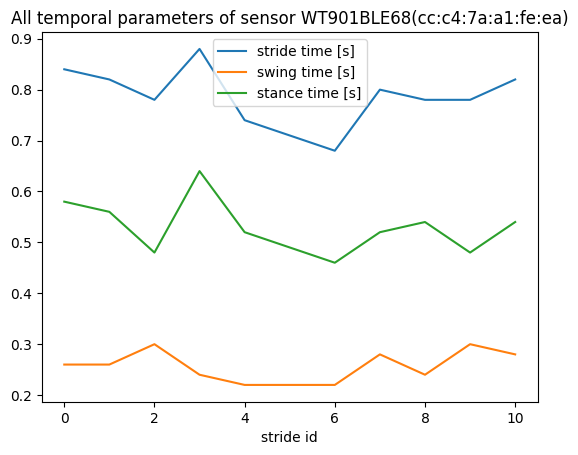

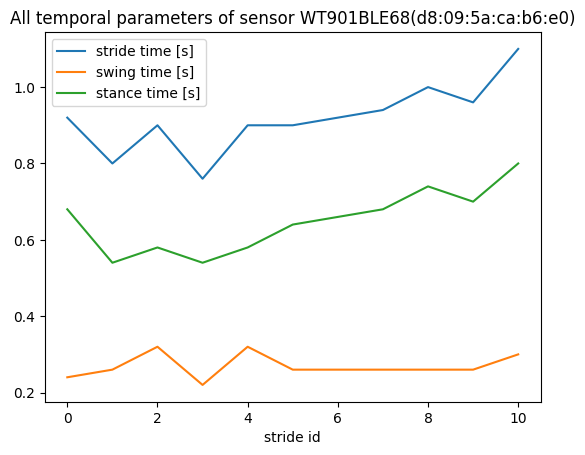

In [334]:
strides = []
for k, v in temporal_paras.parameters_pretty_.items():
    strides.append(len(v))
    v.plot()
    plt.title(f"All temporal parameters of sensor {k}")

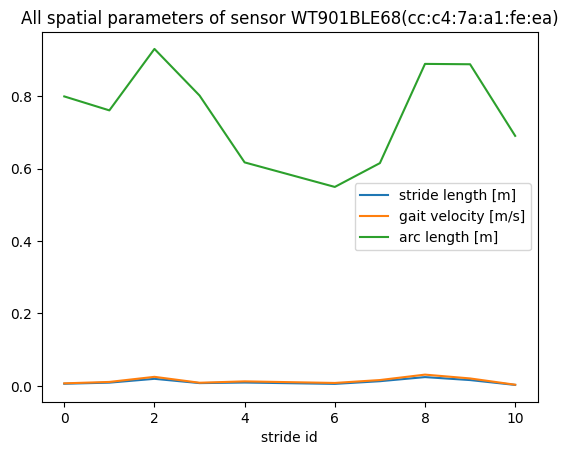

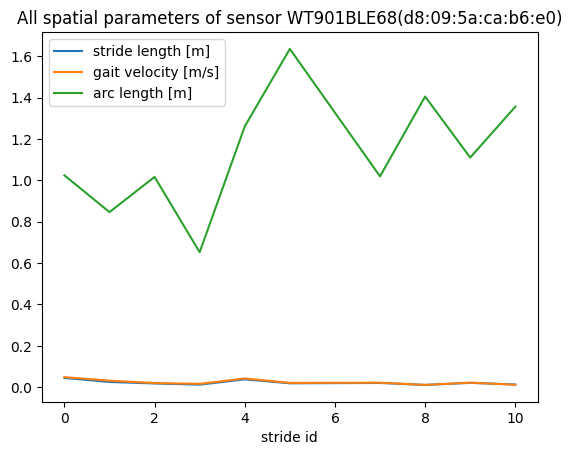

In [335]:
for k, v in spatial_paras.parameters_pretty_.items():
    v[["stride length [m]", "gait velocity [m/s]", "arc length [m]"]].plot()
    plt.title(f"All spatial parameters of sensor {k}")

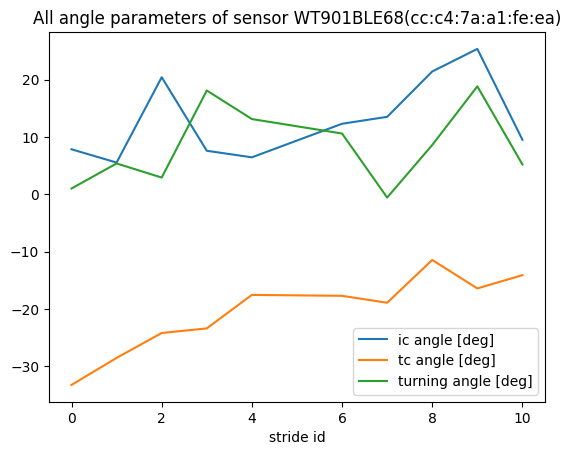

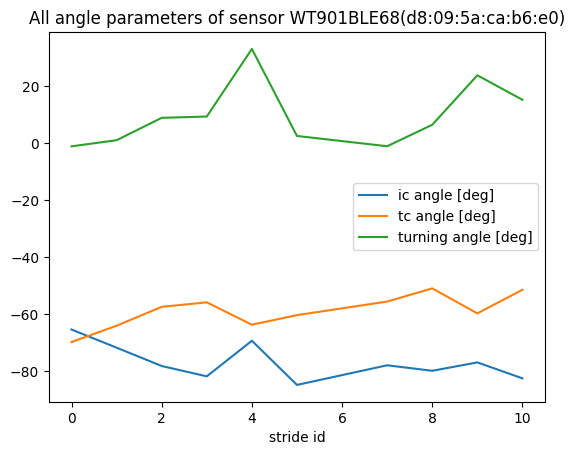

In [336]:
for k, v in spatial_paras.parameters_pretty_.items():
    v.filter(like="angle").plot()
    plt.title(f"All angle parameters of sensor {k}")

In [337]:
for k, v in spatial_paras.parameters_pretty_.items():
    print(k,v)

WT901BLE68(cc:c4:7a:a1:fe:ea)            arc length [m]  gait velocity [m/s]  ic angle [deg]   
stride id                                                        
0                0.799577             0.006951        7.860727  \
1                0.761020             0.010838        5.541883   
2                0.930780             0.024930       20.445029   
3                0.802068             0.008614        7.600509   
4                0.617304             0.012405        6.457347   
6                0.549533             0.008034       12.319656   
7                0.615338             0.016060       13.528965   
8                0.889420             0.031044       21.451422   
9                0.888409             0.020497       25.390226   
10               0.690608             0.003154        9.526136   

           max. lateral excursion [m]  max. orientation change [deg]   
stride id                                                              
0                            0.00

In [338]:
for k, v in temporal_paras.parameters_pretty_.items():
    print(k,v)

WT901BLE68(cc:c4:7a:a1:fe:ea)            stride time [s]  swing time [s]  stance time [s]
stride id                                                  
0                     0.84            0.26             0.58
1                     0.82            0.26             0.56
2                     0.78            0.30             0.48
3                     0.88            0.24             0.64
4                     0.74            0.22             0.52
6                     0.68            0.22             0.46
7                     0.80            0.28             0.52
8                     0.78            0.24             0.54
9                     0.78            0.30             0.48
10                    0.82            0.28             0.54
WT901BLE68(d8:09:5a:ca:b6:e0)            stride time [s]  swing time [s]  stance time [s]
stride id                                                  
0                     0.92            0.24             0.68
1                     0.80            0.

In [339]:
x = temporal_paras.parameters_pretty_.values()

In [340]:
y = list(x)

In [341]:
strides

[10, 10]

cc: right; d8: left

In [342]:
temporal_left = y[0]
temporal_right = y[1]

In [343]:
temporal_left

,stride time [s],swing time [s],stance time [s]
stride id,,,
0,0.84,0.26,0.58
1,0.82,0.26,0.56
2,0.78,0.30,0.48
3,0.88,0.24,0.64
4,0.74,0.22,0.52
6,0.68,0.22,0.46
7,0.80,0.28,0.52
8,0.78,0.24,0.54
9,0.78,0.30,0.48


In [344]:
temporal_right

,stride time [s],swing time [s],stance time [s]
stride id,,,
0,0.92,0.24,0.68
1,0.80,0.26,0.54
2,0.90,0.32,0.58
3,0.76,0.22,0.54
4,0.90,0.32,0.58
5,0.90,0.26,0.64
7,0.94,0.26,0.68
8,1.00,0.26,0.74
9,0.96,0.26,0.70


In [345]:
mean_stride_time_left = temporal_left.loc[:, 'stride time [s]'].mean()
mean_stride_time_left

0.792

In [346]:
mean_stride_time_right = temporal_right.loc[:, 'stride time [s]'].mean()
mean_stride_time_right

0.9180000000000001

In [347]:
mean_stride_time = (mean_stride_time_right + mean_stride_time_left) / 2
mean_stride_time = round(mean_stride_time)
mean_stride_time

1

In [348]:
temporal_right

,stride time [s],swing time [s],stance time [s]
stride id,,,
0,0.92,0.24,0.68
1,0.80,0.26,0.54
2,0.90,0.32,0.58
3,0.76,0.22,0.54
4,0.90,0.32,0.58
5,0.90,0.26,0.64
7,0.94,0.26,0.68
8,1.00,0.26,0.74
9,0.96,0.26,0.70


In [349]:
temporal = pd.concat([temporal_left, temporal_right])

In [350]:
a = spatial_paras.parameters_pretty_.values()
b = list(a)
spatial_left = b[0]
spatial_right = b[1]

In [351]:
spatial_left

,arc length [m],gait velocity [m/s],ic angle [deg],max. lateral excursion [m],max. orientation change [deg],max. sensor lift [m],stride length [m],tc angle [deg],turning angle [deg]
stride id,,,,,,,,,
0,0.799577,0.006951,7.860727,0.001467,44.959364,0.0,0.005839,-33.294707,1.009545
1,0.761020,0.010838,5.541883,0.000480,38.638123,0.0,0.008887,-28.575618,5.388592
2,0.930780,0.024930,20.445029,0.000806,49.772690,0.0,0.019446,-24.225403,2.922129
3,0.802068,0.008614,7.600509,0.003480,33.118612,0.0,0.007580,-23.422455,18.128222
4,0.617304,0.012405,6.457347,0.001148,28.529403,0.0,0.009179,-17.569668,13.140025
6,0.549533,0.008034,12.319656,0.001342,32.941170,0.0,0.005463,-17.731238,10.613676
7,0.615338,0.016060,13.528965,0.001845,35.923992,0.0,0.012848,-18.942353,-0.571973
8,0.889420,0.031044,21.451422,0.001977,37.870155,0.0,0.024214,-11.467158,8.612751
9,0.888409,0.020497,25.390226,0.002729,47.797227,0.0,0.015988,-16.441865,18.854908


In [352]:
def calculate_peak_angular_velocity(gyr_x, gyr_y, gyr_z):
    # Calculate the magnitude of the angular velocity vector
    angular_velocity_magnitude = np.sqrt(gyr_x**2 + gyr_y**2 + gyr_z**2)
    return angular_velocity_magnitude  # This returns the magnitude per row

example_dataset_left = dfs_dict['WT901BLE68(d8:09:5a:ca:b6:e0)']
example_dataset_right = dfs_dict['WT901BLE68(cc:c4:7a:a1:fe:ea)']
# Assuming 'data' is your DataFrame
# Apply the function to each row
pav_left = pd.DataFrame()
pav_left['pav']= example_dataset_left.apply(
    lambda row: calculate_peak_angular_velocity(row['ω_x'], row['ω_y'], row['ω_z']),
    axis=1
)

pav_right = pd.DataFrame()
pav_right['pav']= example_dataset_right.apply(
    lambda row: calculate_peak_angular_velocity(row['ω_x'], row['ω_y'], row['ω_z']),
    axis=1
)

In [353]:
import pandas as pd
import numpy as np

# Assuming `angular_velocity_data` contains your angular velocity data with columns 'ω_x', 'ω_y', 'ω_z'
# and `stride_data` contains your stride data with columns 'stride time [s]', etc.

# Function to calculate peak angular velocity for a DataFrame slice
def calculate_peak_angular_velocity(gyr_x, gyr_y, gyr_z):
    angular_velocity_magnitude = np.sqrt(gyr_x**2 + gyr_y**2 + gyr_z**2)
    # Use a percentile to cap extreme values
    peak_velocity = np.percentile(angular_velocity_magnitude, 95)
    return peak_velocity

# Iterate over each stride to calculate the peak angular velocity for that stride
peak_angular_velocities_left = []
sampling_rate = 50  # Adjust as needed

for index, row in temporal_left.iterrows():
    stride_time = row['stride time [s]']
    stride_samples = int(stride_time * sampling_rate)
    
    # Get the slice of angular velocity data for the current stride
    start_index = index * stride_samples
    end_index = start_index + stride_samples
    
    # Ensure index bounds are valid
    if end_index > len(example_dataset_left.loc[:,['ω_x', 'ω_y', 'ω_z']]):
        end_index = len(example_dataset_left.loc[:,['ω_x', 'ω_y', 'ω_z']])
    
    stride_slice = example_dataset_left.loc[:,['ω_x', 'ω_y', 'ω_z']].iloc[start_index:end_index]
    
    # Calculate the peak angular velocity for this stride slice
    peak_velocity = calculate_peak_angular_velocity(
        stride_slice['ω_x'],
        stride_slice['ω_y'],
        stride_slice['ω_z']
    )
    peak_angular_velocities_left.append(peak_velocity)

# Add the results to the stride DataFrame
pavleft = pd.DataFrame()
pavleft['peak_angular_velocity'] = peak_angular_velocities_left
pavleft['peak_angular_velocity'] /= 40
# Display the updated stride DataFrame
print(pavleft)


   peak_angular_velocity
0             243.392665
1             223.974907
2             260.716745
3             233.857451
4             217.687545
5             242.549163
6             390.442545
7             395.388829
8             368.683325
9             304.598219


In [354]:
peak_angular_velocities_right = []
for index, row in temporal_right.iterrows():
    stride_time = row['stride time [s]']
    stride_samples = int(stride_time * sampling_rate)
    
    # Get the slice of angular velocity data for the current stride
    start_index = index * stride_samples
    end_index = start_index + stride_samples
    
    # Ensure index bounds are valid
    if end_index > len(example_dataset_right.loc[:,['ω_x', 'ω_y', 'ω_z']]):
        end_index = len(example_dataset_right.loc[:,['ω_x', 'ω_y', 'ω_z']])
    
    stride_slice = example_dataset_right.loc[:,['ω_x', 'ω_y', 'ω_z']].iloc[start_index:end_index]
    
    # Calculate the peak angular velocity for this stride slice
    peak_velocity = calculate_peak_angular_velocity(
        stride_slice['ω_x'],
        stride_slice['ω_y'],
        stride_slice['ω_z']
    )
    peak_angular_velocities_right.append(peak_velocity)

# Add the results to the stride DataFrame
pavright = pd.DataFrame()
pavright['peak_angular_velocity'] = peak_angular_velocities_right
pavright['peak_angular_velocity'] /= 400
pavright = pavright.head(10)
# Display the updated stride DataFrame
print(pavright)


   peak_angular_velocity
0             294.199654
1             290.125032
2             282.814697
3             280.170574
4             420.639553
5             284.253575
6             464.806402
7             310.614065
8             352.359196
9             240.984046


In [355]:
# Extract relevant columns (adjust as needed)
from scipy.signal import welch

stride_time_left = temporal_left['stride time [s]']
swing_time_left = temporal_left['swing time [s]']
stance_time_left = temporal_left['stance time [s]']
acc_x_left = data['WT901BLE68(d8:09:5a:ca:b6:e0)']['acc_x']
acc_y_left = data['WT901BLE68(d8:09:5a:ca:b6:e0)']['acc_y']
acc_z_left = data['WT901BLE68(d8:09:5a:ca:b6:e0)']['acc_z']
gyr_x_left = data['WT901BLE68(d8:09:5a:ca:b6:e0)']['gyr_x']
gyr_y_left = data['WT901BLE68(d8:09:5a:ca:b6:e0)']['gyr_y']
gyr_z_left = data['WT901BLE68(d8:09:5a:ca:b6:e0)']['gyr_z']

stride_time_right = temporal_right['stride time [s]']
swing_time_right = temporal_right['swing time [s]']
stance_time_right = temporal_right['stance time [s]']
acc_x_right = data['WT901BLE68(cc:c4:7a:a1:fe:ea)']['acc_x']
acc_y_right = data['WT901BLE68(cc:c4:7a:a1:fe:ea)']['acc_y']
acc_z_right = data['WT901BLE68(cc:c4:7a:a1:fe:ea)']['acc_z']
gyr_x_right = data['WT901BLE68(cc:c4:7a:a1:fe:ea)']['gyr_x']
gyr_y_right = data['WT901BLE68(cc:c4:7a:a1:fe:ea)']['gyr_y']
gyr_z_right = data['WT901BLE68(cc:c4:7a:a1:fe:ea)']['gyr_z']

fs = 50  # Sample rate in Hz (adjust based on your data)
stride_window_size = 2  # Number of strides per window
window_length = int(1 * fs)  # 1-second window length in samples

# Function to compute power in specific frequency bands
def compute_power_ratio(signal, fs):
    # Perform FFT
    n = len(signal)
    freqs = np.fft.rfftfreq(n, d=1/fs)
    fft_values = np.fft.rfft(signal)
    power_spectrum = np.abs(fft_values) ** 2 / n

    # Total power in freeze band (3-8 Hz)
    freeze_band_power = np.sum(power_spectrum[(freqs >= 3) & (freqs <= 8)] ** 2)

    # Total power in locomotor band (0.5-3 Hz)
    locomotor_band_power = np.sum(power_spectrum[(freqs >= 0.5) & (freqs < 3)] ** 2)

    # Compute forward freeze index
    if locomotor_band_power > 0:
        freeze_index = freeze_band_power / locomotor_band_power
    else:
        freeze_index = np.nan  # Avoid division by zero

    return freeze_index

# Sliding window approach to calculate freeze index per window
freeze_indices_left = []
for i in range(0, len(acc_y_left) - window_length, window_length):
    window_signal = acc_y_left[i:i + window_length]
    freeze_idx = compute_power_ratio(window_signal, fs)
    freeze_indices_left.append(freeze_idx)

freeze_indices_right = []
for i in range(0, len(acc_y_right) - window_length, window_length):
    window_signal = acc_y_right[i:i + window_length]
    freeze_idx = compute_power_ratio(window_signal, fs)
    if freeze_idx > 10 and freeze_idx< 100:
        freeze_idx /= 10
    if freeze_idx > 100:
        freeze_idx /= 100
    freeze_indices_right.append(freeze_idx -1)
# Add results back to the DataFrame or print them


min_val = min(freeze_indices_right)
max_val = max(freeze_indices_right)
freeze_indices_right = [(x - min_val) / (max_val - min_val) for x in freeze_indices_right]
freezedf = pd.DataFrame()
freezedf['left'] = freeze_indices_left[:10]
freezedf['right'] = freeze_indices_right[:10]
print("Freeze indices left computed for each 1s window:", freeze_indices_left)
print("Freeze indices right computed for each 1s window:", freeze_indices_right)
freezedf

Freeze indices left computed for each 1s window: [0.47963866190179133, 0.30569005843346103, 0.40985549857765075, 0.7616675193402425, 0.03951579638117895, 0.9348453079112221, 1.6551845849073075, 0.4870764483865558, 0.292802884974458, 0.434683718333117, 0.347309408993093, 0.6984699187021695, 0.3711150245291961]
Freeze indices right computed for each 1s window: [0.0, 0.6115011044689049, 0.5310365923080038, 0.44523614403000844, 0.23630986550939595, 0.0803326661276552, 0.42058439551698584, 1.0, 0.0006624104270435742, 0.12624645325761769, 0.46437537492962233]


,left,right
0,0.479639,0.000000
1,0.305690,0.611501
2,0.409855,0.531037
3,0.761668,0.445236
4,0.039516,0.236310
5,0.934845,0.080333
6,1.655185,0.420584
7,0.487076,1.000000
8,0.292803,0.000662
9,0.434684,0.126246


In [356]:
avg_freeze_index_left = sum(freeze_indices_left) / len(freeze_indices_left)
avg_freeze_index_left

0.555219602413188

In [357]:
avg_freeze_index_right = sum(freeze_indices_right) / len(freeze_indices_right)
avg_freeze_index_right

0.356025909688658

In [358]:
import pandas as pd
import numpy as np

# Example parameters: Replace with actual sample rate and angle data
sampling_rate = 50  # in Hz (samples per second)

# Load your angle data as a DataFrame (example column names)
# Replace with your actual data source if needed
example_dataset_left = dfs_dict['WT901BLE68(d8:09:5a:ca:b6:e0)']
example_dataset_right = dfs_dict['WT901BLE68(cc:c4:7a:a1:fe:ea)']
angle_data_left = example_dataset_left.loc[:, ['Angle X(°)', 'Angle Y(°)', 'Angle Z(°)']]
angle_data_right = example_dataset_right.loc[:, ['Angle X(°)', 'Angle Y(°)', 'Angle Z(°)']]

angle_data_right



,Angle X(°),Angle Y(°),Angle Z(°)
0,0.341,-88.088,152.281
1,0.829,-88.121,151.853
2,0.862,-88.121,151.897
3,0.577,-88.220,152.342
4,-0.588,-88.248,153.583
...,...,...,...
594,-100.432,-64.440,-152.260
595,-99.261,-64.435,-152.155
596,-96.575,-66.000,-153.523
597,-94.345,-69.554,-154.440


In [359]:
angle_data_left

,Angle X(°),Angle Y(°),Angle Z(°)
0,-87.913,5.532,113.774
1,-87.841,5.537,113.840
2,-87.583,5.460,114.027
3,-87.523,5.466,114.109
4,-87.440,5.515,114.164
...,...,...,...
657,-87.567,8.069,-11.168
658,-87.435,8.300,-11.080
659,-87.303,8.481,-11.047
660,-87.369,8.701,-11.014


In [360]:

# Load your stride, swing, and stance time data (as shown in your input)
stride_data = temporal_left

# Function to calculate angular range during the swing phase
def calculate_swing_angular_range(angle_data, swing_time, sampling_rate):
    swing_samples = int(swing_time * sampling_rate)  # Number of samples in the swing phase
    swing_data = angle_data.iloc[:swing_samples]  # Adjust the range to the swing phase duration
    angular_range = swing_data.max() - swing_data.min()  # Range calculation
    return angular_range

# Apply the function for each stride
results = []
for index, row in stride_data.iterrows():
    swing_time = row['swing time [s]']
    swing_start_index = 0  # Assume you start from index 0 or set as needed
    swing_end_index = int(swing_time * sampling_rate)
    
    # Ensure your actual angle data slicing corresponds to each stride's swing phase
    angle_slice = angle_data_left.iloc[swing_start_index:swing_end_index]  # Replace with actual slicing logic
    swing_range = calculate_swing_angular_range(angle_slice, swing_time, sampling_rate)
    results.append(swing_range)

# Display results for each stride
for i, result in enumerate(results):
    print(f"Stride {i}: Swing Angular Range (degrees):\n{result}\n")


Stride 0: Swing Angular Range (degrees):
Angle X(°)    1.077
Angle Y(°)    0.972
Angle Z(°)    1.209
dtype: float64

Stride 1: Swing Angular Range (degrees):
Angle X(°)    1.077
Angle Y(°)    0.972
Angle Z(°)    1.209
dtype: float64

Stride 2: Swing Angular Range (degrees):
Angle X(°)    1.077
Angle Y(°)    1.049
Angle Z(°)    1.209
dtype: float64

Stride 3: Swing Angular Range (degrees):
Angle X(°)    1.077
Angle Y(°)    0.747
Angle Z(°)    1.209
dtype: float64

Stride 4: Swing Angular Range (degrees):
Angle X(°)    1.055
Angle Y(°)    0.571
Angle Z(°)    1.159
dtype: float64

Stride 5: Swing Angular Range (degrees):
Angle X(°)    1.055
Angle Y(°)    0.571
Angle Z(°)    1.159
dtype: float64

Stride 6: Swing Angular Range (degrees):
Angle X(°)    1.077
Angle Y(°)    1.016
Angle Z(°)    1.209
dtype: float64

Stride 7: Swing Angular Range (degrees):
Angle X(°)    1.077
Angle Y(°)    0.747
Angle Z(°)    1.209
dtype: float64

Stride 8: Swing Angular Range (degrees):
Angle X(°)    1.077
Ang

In [361]:
# Initialize a list to store the average angular ranges for each stride
average_swing_ranges = []

# Apply the function for each stride and calculate average X, Y, Z angular ranges
for index, row in stride_data.iterrows():
    swing_time = row['swing time [s]']
    
    # Adjust the slicing for the actual angle data
    swing_start_index = 0  # For example; adjust based on actual data structure
    swing_end_index = int(swing_time * sampling_rate)
    
    # Slice the angle data for the left foot (X, Y, Z axes)
    angle_slice_left = angle_data_left[['Angle X(°)', 'Angle Y(°)', 'Angle Z(°)']].iloc[swing_start_index:swing_end_index]
    
    # Calculate the angular range for each axis (X, Y, Z)
    angular_range_left = calculate_swing_angular_range(angle_slice_left, swing_time, sampling_rate)
    
    # Calculate the mean angular range for the current stride (averaging across X, Y, Z)
    avg_left_range = angular_range_left.mean()  # Mean of X, Y, Z ranges
    
    # Append to results list
    average_swing_ranges.append(avg_left_range)

swing_left = pd.DataFrame()
# Add the average swing range as a new column in stride_data DataFrame
swing_left['average_swing_range'] = average_swing_ranges

# Display the updated DataFrame
print(swing_left)

   average_swing_range
0             1.086000
1             1.086000
2             1.111667
3             1.011000
4             0.928333
5             0.928333
6             1.100667
7             1.011000
8             1.111667
9             1.100667


In [362]:

# Load your stride, swing, and stance time data (as shown in your input)
stride_data = temporal_right

# Function to calculate angular range during the swing phase
def calculate_swing_angular_range(angle_data, swing_time, sampling_rate):
    swing_samples = int(swing_time * sampling_rate)  # Number of samples in the swing phase
    swing_data = angle_data.iloc[:swing_samples]  # Adjust the range to the swing phase duration
    angular_range = swing_data.max() - swing_data.min()  # Range calculation
    return angular_range

# Apply the function for each stride
results = []
for index, row in stride_data.iterrows():
    swing_time = row['swing time [s]']
    swing_start_index = 0  # Assume you start from index 0 or set as needed
    swing_end_index = int(swing_time * sampling_rate)
    
    # Ensure your actual angle data slicing corresponds to each stride's swing phase
    angle_slice = angle_data_right.iloc[swing_start_index:swing_end_index]  # Replace with actual slicing logic
    swing_range = calculate_swing_angular_range(angle_slice, swing_time, sampling_rate)
    results.append(swing_range)

# Display results for each stride
for i, result in enumerate(results):
    print(f"Stride {i}: Swing Angular Range (degrees):\n{result}\n")


Stride 0: Swing Angular Range (degrees):
Angle X(°)    10.607
Angle Y(°)     0.226
Angle Z(°)    11.140
dtype: float64

Stride 1: Swing Angular Range (degrees):
Angle X(°)    13.975
Angle Y(°)     0.495
Angle Z(°)    13.980
dtype: float64

Stride 2: Swing Angular Range (degrees):
Angle X(°)    67.006
Angle Y(°)     1.039
Angle Z(°)    66.923
dtype: float64

Stride 3: Swing Angular Range (degrees):
Angle X(°)    10.607
Angle Y(°)     0.160
Angle Z(°)    11.140
dtype: float64

Stride 4: Swing Angular Range (degrees):
Angle X(°)    67.006
Angle Y(°)     1.039
Angle Z(°)    66.923
dtype: float64

Stride 5: Swing Angular Range (degrees):
Angle X(°)    13.975
Angle Y(°)     0.495
Angle Z(°)    13.980
dtype: float64

Stride 6: Swing Angular Range (degrees):
Angle X(°)    13.975
Angle Y(°)     0.495
Angle Z(°)    13.980
dtype: float64

Stride 7: Swing Angular Range (degrees):
Angle X(°)    13.975
Angle Y(°)     0.495
Angle Z(°)    13.980
dtype: float64

Stride 8: Swing Angular Range (degrees):

In [363]:
# Initialize a list to store the average angular ranges for each stride
average_swing_ranges = []

# Apply the function for each stride and calculate average X, Y, Z angular ranges
for index, row in stride_data.iterrows():
    swing_time = row['swing time [s]']
    
    # Adjust the slicing for the actual angle data
    swing_start_index = 0  # For example; adjust based on actual data structure
    swing_end_index = int(swing_time * sampling_rate)
    
    # Slice the angle data for the right foot (X, Y, Z axes)
    angle_slice_right = angle_data_right[['Angle X(°)', 'Angle Y(°)', 'Angle Z(°)']].iloc[swing_start_index:swing_end_index]
    
    # Calculate the angular range for each axis (X, Y, Z)
    angular_range_right = calculate_swing_angular_range(angle_slice_right, swing_time, sampling_rate)
    
    # Calculate the mean angular range for the current stride (averaging across X, Y, Z)
    avg_right_range = angular_range_right.mean()  # Mean of X, Y, Z ranges
    
    # Append to results list
    average_swing_ranges.append(avg_right_range)

swing_right = pd.DataFrame()
# Add the average swing range as a new column in stride_data DataFrame
swing_right['average_swing_range'] = average_swing_ranges

# Display the updated DataFrame
print(swing_right)

   average_swing_range
0             7.324333
1             9.483333
2            44.989333
3             7.302333
4            44.989333
5             9.483333
6             9.483333
7             9.483333
8             9.483333
9            33.424333


In [364]:
temporal_left

,stride time [s],swing time [s],stance time [s]
stride id,,,
0,0.84,0.26,0.58
1,0.82,0.26,0.56
2,0.78,0.30,0.48
3,0.88,0.24,0.64
4,0.74,0.22,0.52
6,0.68,0.22,0.46
7,0.80,0.28,0.52
8,0.78,0.24,0.54
9,0.78,0.30,0.48


In [365]:
result_df = pd.DataFrame({
        'Patient ID number': 0,
        'Number of total left steps': strides[1], # left: d8
        'Times of peak angular velocity on left shank': temporal_left['stance time [s]'],
        'Left gait cycle (stride time) durations': temporal_left['stride time [s]'],
        'Left swing time durations': temporal_left['swing time [s]'],
        'Left swing angular ranges': swing_left['average_swing_range'],
        'Peak shank angular velocity (left)':pavleft['peak_angular_velocity'],
        'Freeze index (left accelerometer)': freezedf['left'],
        'Left leg identifier': 0,
        'Number of total right steps': strides[0], # right: cc
        'Times of peak angular velocity on right shank': temporal_right['stance time [s]'],
        'Right gait cycle (stride time) durations': temporal_right['stride time [s]'],
        'Right swing time durations ': temporal_right['swing time [s]'],
        'Right swing angular ranges': swing_right['average_swing_range'],
        'Peak shank angular velocity (right)': pavright['peak_angular_velocity'],
        'Freeze index (right accelerometer)': freezedf['right'],
        'Right leg identifier': 1
    })

In [366]:
result_df = result_df.dropna()
result_df

,Patient ID number,Number of total left steps,Times of peak angular velocity on left shank,Left gait cycle (stride time) durations,Left swing time durations,Left swing angular ranges,Peak shank angular velocity (left),Freeze index (left accelerometer),Left leg identifier,Number of total right steps,Times of peak angular velocity on right shank,Right gait cycle (stride time) durations,Right swing time durations,Right swing angular ranges,Peak shank angular velocity (right),Freeze index (right accelerometer),Right leg identifier
0,0,10,0.58,0.84,0.26,1.086000,243.392665,0.479639,0,10,0.68,0.92,0.24,7.324333,294.199654,0.000000,1
1,0,10,0.56,0.82,0.26,1.086000,223.974907,0.305690,0,10,0.54,0.80,0.26,9.483333,290.125032,0.611501,1
2,0,10,0.48,0.78,0.30,1.111667,260.716745,0.409855,0,10,0.58,0.90,0.32,44.989333,282.814697,0.531037,1
3,0,10,0.64,0.88,0.24,1.011000,233.857451,0.761668,0,10,0.54,0.76,0.22,7.302333,280.170574,0.445236,1
4,0,10,0.52,0.74,0.22,0.928333,217.687545,0.039516,0,10,0.58,0.90,0.32,44.989333,420.639553,0.236310,1
7,0,10,0.52,0.80,0.28,1.011000,395.388829,0.487076,0,10,0.68,0.94,0.26,9.483333,310.614065,1.000000,1
8,0,10,0.54,0.78,0.24,1.111667,368.683325,0.292803,0,10,0.74,1.00,0.26,9.483333,352.359196,0.000662,1
9,0,10,0.48,0.78,0.30,1.100667,304.598219,0.434684,0,10,0.70,0.96,0.26,33.424333,240.984046,0.126246,1


In [367]:
#result_df.to_csv('readings1.csv')